In [1]:
import os
import re
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import textwrap
import pickle
import torch
from accelerate import init_empty_weights, Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from custom_modeling_opt import CustomOPTForCausalLM
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
seed_value=42
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
import rdkit.Chem as Chem
import sys
from rdkit.Chem import RDConfig, MACCSkeys, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcCrippenDescriptors
from rdkit.Chem import Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [4]:
import moses

/home/menuab/miniconda3/envs/chemlactica2/lib/python3.10/site-packages/molsets-1.0-py3.10.egg/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


In [5]:
device = "cuda:1"

In [6]:
tokenizer = AutoTokenizer.from_pretrained("/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
print('tokenizer size: ', len(tokenizer))

tokenizer size:  50066


In [7]:
checkpoint_path = "/home/menuab/code/checkpoints/f2c6ebb289994595a478f513/125m_126k_f2c6/"
checkpoint_path = "/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/"
checkpoint_path

'/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/'

In [8]:
model = CustomOPTForCausalLM.from_pretrained(
            checkpoint_path,
            use_flash_attn=True,
            torch_dtype=torch.bfloat16
            )
model.eval()
model.to(device)
print(f'model loaded with embedding size of : {model.model.decoder.embed_tokens.num_embeddings}')
assert(model.model.decoder.embed_tokens.num_embeddings == len(tokenizer))

model loaded with embedding size of : 50066


In [9]:
moses_df = pd.read_csv('./data/dataset_v1.csv')
moses_df.head()

,SMILES,SPLIT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train


In [10]:
moses_df[['SAS', 'QED', 'CLOGP', 'WEIGHT']] = 0

In [11]:
moses_df.head()

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,0,0,0,0
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,0,0,0,0
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test,0,0,0,0
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,0,0,0,0
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,0,0,0,0


In [12]:
moses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936962 entries, 0 to 1936961
Data columns (total 6 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   SMILES  object
 1   SPLIT   object
 2   SAS     int64 
 3   QED     int64 
 4   CLOGP   int64 
 5   WEIGHT  int64 
dtypes: int64(4), object(2)
memory usage: 88.7+ MB


In [13]:
# Define the worker function
def process_molecule(mol):
    print(mol)
    try:
        mol_source = Chem.MolFromSmiles(mol)
        sas_score = sascorer.calculateScore(mol_source) 
        qed_score = round(QED.qed(mol_source), 3)
        clogp_score = round(Descriptors.MolLogP(mol_source), 3)
        weight_score = round(Descriptors.ExactMolWt(mol_source), 3)
        return sas_score, qed_score, clogp_score, weight_score
    except:
        return None

# Main function to use multiprocessing
def process_many_molecules(df):
    # Create a pool of workers
    with multiprocessing.Pool(20) as pool:
        # Process the molecules using the pool
        results = list(tqdm(pool.imap(process_molecule, df.iloc[:,0]), total=len(df)))
    # print(len(results))

    # Store the results back into the DataFrame
    for en, (sas_score, qed_score, clogp_score, weight_score) in enumerate(results):
        df.iloc[en, 2] = sas_score
        df.iloc[en, 3] = qed_score
        df.iloc[en, 4] = clogp_score
        df.iloc[en, 5] = weight_score

In [ ]:
process_many_molecules(moses_df)

CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2CO=C(C1CCCCC1)N1CC(=O)N2CCCc3ccccc3C2C1CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=OCOc1ccccc1OC(=O)c1ccccc1OC(C)=O
O=C1Nc2ccc(Cl)cc2C(c2ccccc2Cl)=NC1O

  0%|          | 0/1936962 [00:00<?, ?it/s]




CN1C(=O)C(O)N=C(c2ccccc2Cl)c2cc(Cl)ccc21CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)COCCC(=O)c1ccc(OCC(O)CO)c(OC)c1

COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1COc1cc(C)c(Cc2cnc(N)nc2N)cc1OC
CCOC(=O)c1cncn1C1CCCc2ccccc21CC1CC(OC(=O)CN2CCCC2=O)CC(C)(C)C1

Cc1nc2c([nH]1)c(=O)n(C)c(=O)n2CC1CC=CCC1

COc1ccccc1OC(=O)Oc1ccccc1OC



O=C1Nc2ccc(Cl)cc2C(c2ccccc2)=NC1O


COc1cc2c(cc1O)N=CC1CCC(O)N1C2=OCOc1c(C)cnc(CS(=O)c2nc3ccccc3[nH]2)c1C

O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1CCC1NC(=O)c2cc(S(N)(=O)=O)c(Cl)cc2N1

COC(=O)c1c[nH]c2cc(OC(C)C)c(OC(C)C)cc2c1=O
CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1CN1C(=O)C(O)N=C(c2ccccc2)c2cc(Cl)ccc21

COc1cc(C(=O)N2CCOCC2)cc(OC)c1OC
COc1ccc(C=C2CCCN=C2c2cccnc2)c(OC)c1CC(c1ncncc1F)C(O)(Cn1cncn1)c1ccc(F)cc1F
CC(=O)Nc1ccc(S(=O)(=O)c2ccc(NC(C)=O)cc2)cc1
CC(=O)Oc1cccc(OC(C)=O)c1OC(C)=O
CC(=O)Oc1cc(C)c(OC(C)=O)c2ccccc12
CC(C)C=c1[nH]c(=O)c(=Cc2ccccc2)[nH]c1=O
CC(=O)Nc1ccc(OC(=O)c2ccccc2O)cc1
Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1)=NC2CC1(C)C(=O)Nc2cc3nc

In [1]:
moses_df

NameError: name 'moses_df' is not defined

In [ ]:
moses.to_csv('moses_calculated.csv')

In [ ]:
moses_df = pd.read_csv('moses_calculated.csv')

In [10]:
moses_df = moses_df[moses_df.SPLIT == 'train']
moses_df.head()

,SMILES,SPLIT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train
5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train


In [47]:
moses_df.head(20)

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,3.812618,0.897,1.681,281.083
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,2.936327,0.862,3.729,292.098
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,2.663795,0.701,2.297,336.088
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,2.989161,0.646,-2.213,254.102
5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train,3.055750,0.853,0.807,271.061
...,...,...,...,...,...,...
2400,CC(=O)NC1(C(Cl)(Cl)Cl)Oc2ccccc2O1,train,2.917217,0.810,2.618,294.957
2402,CC(=O)NC1(C(F)(F)F)Oc2cc(Cl)c(Cl)cc2O1,train,2.835251,0.866,3.117,314.968
2403,Brc1cccc(-c2nnc3n2CCC3)c1,train,2.148228,0.792,2.654,263.006
2404,Cc1ccc(C(=O)Cn2nnc(-c3ccccc3)n2)cc1,train,1.856366,0.688,2.531,278.117


In [161]:
batch_size = 64

# Initialize lists to store results
targets1, targets2, targets3, targets4 = [], [], [], []
sas_scores, clogp_scores, qed_scores, weight_scores = [], [], [], []
sac_invalids, mols = [], []

# Process in batches
for batch_start in tqdm(range(0, min(1280, len(moses)), batch_size)):
    batch_end = min(batch_start + batch_size, len(moses))
    inputs_batch = []

    for i in range(batch_start, batch_end):
        _, mol, split, sas, qed, clogp, weight = moses.iloc[i, :] # one more column in CSV
        prompt = f"</s>[SAS]{sas:.2f}[/SAS][CLOGP]{clogp:.2f}[/CLOGP][QED]{qed:.2f}[/QED][WEIGHT]{weight:.2f}[/WEIGHT]"
        inputs = tokenizer(prompt, return_tensors="pt").input_ids
        inputs = inputs.to(device)
        # print(inputs.shape, prompt)
        inputs_batch.append(inputs.squeeze(0))  # Remove the extra dimension

    min_length = min([len(i) for i in inputs_batch])

    inputs_batch = torch.stack([i[:min_length] for i in inputs_batch])  # Cutting the last tokens of long sequences
    # print(torch.stack(inputs_batch))

    # Generate outputs for the entire batch
    out = model.generate(inputs_batch, max_new_tokens=600, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)

    # Process outputs for each sequence in the batch
    for seq in out.sequences:
        decoded = tokenizer.decode(seq)
        # print(decoded)
        try:
            if "[END_SMILES]" not in decoded:
                continue
            captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
            mols.append(captured_text)
        except:
            continue


--------
</s>[SAS]3.81[/SAS][CLOGP]1.68[/CLOGP][QED]0.90[/QED][WEIGHT]281.08[/WEIGHT][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][RINGCOUNT]2[/RINGCOUNT][NUMHACCEPTORS]4[/NUMHACCEPTORS][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]7[/NUMHETEROATOMS][HEAVYATOMCOUNT]19[/HEAVYATOMCOUNT][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][NOCOUNT]5[/NOCOUNT][START_SMILES]CC1=C(SC(=N1)N2CCCC(C2)C(=O)O)C(=O)C[END_SMILES]
sas=3.81 sas_score=2.70 qed=0.90 qed_score=0.85 clogp=1.68 clogp_score=1.96 weight=281.08 weight_score=268.09 CC1=C(SC(=N1)N2CCCC(C2)C(=O)O)C(=O)C
--------
</s>[SAS]2.94[/SAS][CLOGP]3.73[/CLOGP][QED]0.86[/QED][WEIGHT]292.10[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMALIPHATICHE

[18:06:22] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]2.99[/CLOGP][QED]0.81[/QED][WEIGHT]270.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMHACCEPTORS]3[/NUMHACCEPTORS][RINGCOUNT]1[/RINGCOUNT][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]4[/NUMHETEROATOMS][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][IUPAC]2-[(2-fluorophenyl)methyl-methylamino]-2-methylpropanoic
[18:06:22] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]2.99[/CLOGP][QED]0.81[/QED][WEIGHT]270.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][

--------
</s>[SAS]1.68[/SAS][CLOGP]3.28[/CLOGP][QED]0.63[/QED][WEIGHT]274.08[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.13[/FRACTIONCSP3][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMHACCEPTORS]2[/NUMHACCEPTORS][NUMHETEROATOMS]4[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][START_SMILES]C1=CC=C(C=C1)COC(=O)CCNC(=O)C2=CC=CC=C2[END_SMILES]
sas=1.68 sas_score=1.49 qed=0.63 qed_score=0.83 clogp=3.28 clogp_score=2.55 weight=274.08 weight_score=283.12 C1=CC=C(C=C1)COC(=O)CCNC(=O)C2=CC=CC=C2
--------
</s>[SAS]2.81[/SAS][CLOGP]3.10[/CLOGP][QED]0.85[/QED][WEIGHT]320.01[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.25[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATA

[18:06:24] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]1.02[/CLOGP][QED]0.71[/QED][WEIGHT]254.12[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]2[/NUMHDONORS][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][FRACTIONCSP3]0.38[/FRACTIONCSP3][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][RINGCOUNT]1[/RINGCOUNT][NUMHACCEPTORS]4[/NUMHACCEPTORS][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][IUPAC]2-[(2-amino-3-methylbutanoyl)-methylamino]-4-fluorobenzoic
[18:06:24] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]1.02[/CLOGP][QED]0.71[/QED][WEIGHT]254.12[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]2[/NUMHDONORS][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][FRACTIONCSP3]0.38[/FRACTIONCSP3][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][RINGCOUNT]1[/RINGCOUNT][NUMHACCEPTORS]4[/NUMHACCEPTO

--------
</s>[SAS]3.30[/SAS][CLOGP]1.09[/CLOGP][QED]0.83[/QED][WEIGHT]274.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMHETEROATOMS]5[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][IUPAC]2-[(2S)-2-(2-fluorophenyl)-2-methyl-3-oxopiperazin-1-yl]-N-methylpropanamide[/IUPAC][NOCOUNT]5[/NOCOUNT][HEAVYATOMCOUNT]20[/HEAVYATOMCOUNT][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F 0.83[/SIMILAR][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)


[18:06:25] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]1.09[/CLOGP][QED]0.83[/QED][WEIGHT]274.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMHETEROATOMS]5[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][IUPAC]2-[(2S)-2-(2-fluorophenyl)-2-methyl-3-oxopiperazin-1-yl]-N-methylpropanamide[/IUPAC][NOCOUNT]5[/NOCOUNT][HEAVYATOMCOUNT]20[/HEAVYATOMCOUNT][SIMILAR]CC(C)C[C@@H](C(=O)N1CCN(CC1)C)NC(=O)C2=CC=CC=C2F
[18:06:25] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]1.09[/CLOGP][QED]0.83[/QED][WEIGHT]274.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[

--------
</s>[SAS]3.79[/SAS][CLOGP]1.04[/CLOGP][QED]0.79[/QED][WEIGHT]262.10[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.50[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][RINGCOUNT]2[/RINGCOUNT][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMHETEROATOMS]7[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHACCEPTORS]5[/NUMHACCEPTORS][NOCOUNT]7[/NOCOUNT][HEAVYATOMCOUNT]19[/HEAVYATOMCOUNT][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][IUPAC]2-[(2S)-2-(2-methyl-1,3-thiazol-4-yl)-2-oxo-1,3-oxazolidin-3-yl]butanoic acid[/IUPAC][NUMSATURATEDRINGS]1[/NUMSATURATEDRINGS][NUMALIPHATICRINGS]1[/NUMALIPHATICRINGS][TPSA]88.83[/TPSA][START_SMILES]CCC(C(=O)O)N1[C@H](COC1=O)C2=CSC(=N2)C[END_SMILES]
sas=3.79 sas_score=3.72 qed=0.79 qed_score=0.90 clogp=1.04 clogp_score=1.81 weight=262.10 weight_score=270.07 CCC(

[18:06:29] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]2.89[/CLOGP][QED]0.86[/QED][WEIGHT]319.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.28[/FRACTIONCSP3][NUMHACCEPTORS]4[/NUMHACCEPTORS][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][IUPAC]N-[(2S)-1-(dimethylamino)-1-oxopropan-2-yl]-2-(4-methylphenyl)-1,3-thiazole-4-carboxamide[/IUPAC][SIMILAR]CC1=CC=C(C=C1)C2=NC(=CS2)C(=O)NCC(=O)N3CCCC3
[18:06:29] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]2.89[/CLOGP][QED]0.86[/QED][WEIGHT]319.14[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLE

--------
</s>[SAS]3.39[/SAS][CLOGP]0.88[/CLOGP][QED]0.75[/QED][WEIGHT]289.03[/WEIGHT][NUMALIPHATICHETEROCYCLES]1[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]3[/NUMROTATABLEBONDS][FRACTIONCSP3]0.50[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]1[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMHACCEPTORS]5[/NUMHACCEPTORS][NUMHETEROATOMS]8[/NUMHETEROATOMS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]1[/NUMSATURATEDHETEROCYCLES][NOCOUNT]6[/NOCOUNT][START_SMILES]C1COCC1(C(=O)O)N2C=C(C=N2)Br[END_SMILES]
sas=3.39 sas_score=3.76 qed=0.75 qed_score=0.86 clogp=0.88 clogp_score=0.85 weight=289.03 weight_score=259.98 C1COCC1(C(=O)O)N2C=C(C=N2)Br
--------
</s>[SAS]2.71[/SAS][CLOGP]2.47[/CLOGP][QED]0.88[/QED][WEIGHT]300.07[/WEIGHT][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.38[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABL

[18:06:32] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]3.77[/CLOGP][QED]0.86[/QED][WEIGHT]308.15[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRACTIONCSP3]0.35[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMHETEROATOMS]4[/NUMHETEROATOMS][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NOCOUNT]3[/NOCOUNT][IUPAC]N-[(2-fluorophenyl)methyl]-2-methyl-2-(2-methylpropyl)-1,3-thiazol-4-amine[/IUPAC][SIMILAR]CC1=NC(=CS1)CNC2=CC=CC=C2F
[18:06:32] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]3.77[/CLOGP][QED]0.86[/QED][WEIGHT]308.15[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMHDONORS]1[/NUMHDONORS][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][FRAC

--------
</s>[SAS]1.73[/SAS][CLOGP]2.44[/CLOGP][QED]0.90[/QED][WEIGHT]332.08[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMHACCEPTORS]3[/NUMHACCEPTORS][NUMHDONORS]1[/NUMHDONORS][FRACTIONCSP3]0.18[/FRACTIONCSP3][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][NOCOUNT]5[/NOCOUNT][START_SMILES]CC1=CC(=C(C=C1)OC)S(=O)(=O)NCC2=CC=CC=C2C#N[END_SMILES]
sas=1.73 sas_score=2.00 qed=0.90 qed_score=0.92 clogp=2.44 clogp_score=2.35 weight=332.08 weight_score=316.09 CC1=CC(=C(C=C1)OC)S(=O)(=O)NCC2=CC=CC=C2C#N
--------
</s>[SAS]2.05[/SAS][CLOGP]3.00[/CLOGP][QED]0.61[/QED][WEIGHT]258.09[/WEIGHT][NUMHDONORS]0[/NUMHDONORS][FRACTIONCSP3]0.07[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIP

[18:06:51] SMILES Parse Error: syntax error while parsing: [/SAS][CLOGP]2.44[/CLOGP][QED]0.78[/QED][WEIGHT]323.13[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][FRACTIONCSP3]0.22[/FRACTIONCSP3][NUMHACCEPTORS]4[/NUMHACCEPTORS][NUMHDONORS]2[/NUMHDONORS][RINGCOUNT]2[/RINGCOUNT][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]0[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NUMHETEROATOMS]6[/NUMHETEROATOMS][IUPAC]N-[2-(2-methoxyanilino)-2-oxoethyl]-2-methyl-3-nitrobenzamide[/IUPAC][NOCOUNT]6[/NOCOUNT][SIMILAR]CC1=C(C=C(C=C1)C(=O)NCC(=O)NC2=CC=CC=C2OC)[N+](=O)[O-]
[18:06:51] SMILES Parse Error: Failed parsing SMILES '[/SAS][CLOGP]2.44[/CLOGP][QED]0.78[/QED][WEIGHT]323.13[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]6[/NUMROTATABLEBONDS][NUMALIPHATICCAR

--------
</s>[SAS]2.30[/SAS][CLOGP]0.65[/CLOGP][QED]0.81[/QED][WEIGHT]294.08[/WEIGHT][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHATICHETEROCYCLES][NUMROTATABLEBONDS]5[/NUMROTATABLEBONDS][NUMHACCEPTORS]5[/NUMHACCEPTORS][NUMHDONORS]2[/NUMHDONORS][RINGCOUNT]2[/RINGCOUNT][FRACTIONCSP3]0.23[/FRACTIONCSP3][NUMALIPHATICCARBOCYCLES]0[/NUMALIPHATICCARBOCYCLES][NUMAROMATICRINGS]2[/NUMAROMATICRINGS][NUMAROMATICHETEROCYCLES]1[/NUMAROMATICHETEROCYCLES][NUMSATURATEDCARBOCYCLES]0[/NUMSATURATEDCARBOCYCLES][NUMSATURATEDHETEROCYCLES]0[/NUMSATURATEDHETEROCYCLES][NUMHETEROATOMS]8[/NUMHETEROATOMS][NOCOUNT]7[/NOCOUNT][START_SMILES]CC1=C(C=C(C=C1)S(=O)(=O)NCC2=NC=NN2)C(=O)O[END_SMILES]
sas=2.30 sas_score=2.28 qed=0.81 qed_score=0.73 clogp=0.65 clogp_score=0.29 weight=294.08 weight_score=296.06 CC1=C(C=C(C=C1)S(=O)(=O)NCC2=NC=NN2)C(=O)O
--------
</s>[SAS]2.07[/SAS][CLOGP]1.17[/CLOGP][QED]0.81[/QED][WEIGHT]264.07[/WEIGHT][NUMHDONORS]2[/NUMHDONORS][FRACTIONCSP3]0.25[/FRACTIONCSP3][NUMALIPHATICHETEROCYCLES]0[/NUMALIPHA

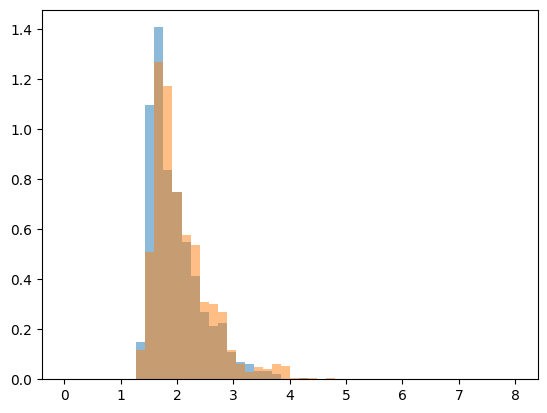

In [154]:
plt.hist(sas_scores, range=(0,8), bins=50, alpha=.5, density=True);
plt.hist(targets1, range=(0,8), bins=50, alpha=.5, density=True);

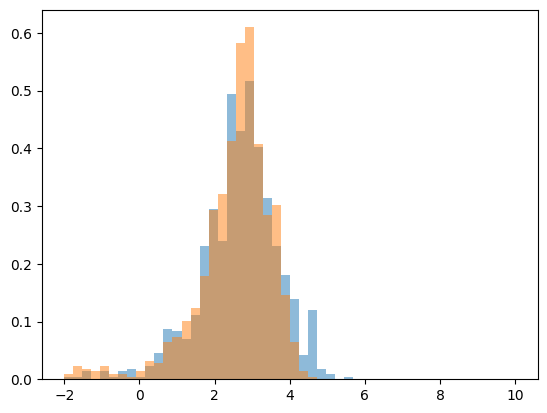

In [155]:
plt.hist(clogp_scores, range=(-2,10), bins=50, alpha=.5, density=True);
plt.hist(targets2, range=(-2,10), bins=50, alpha=.5, density=True);

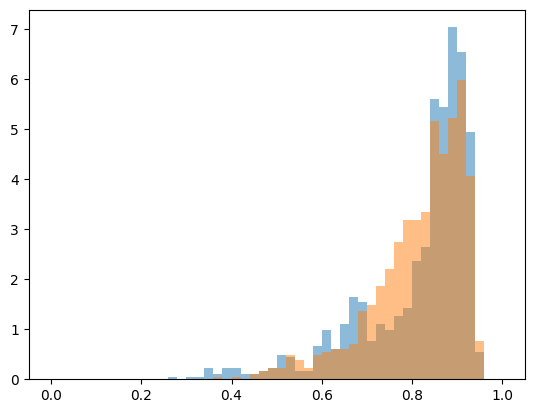

In [156]:
plt.hist(qed_scores, range=(0,1), bins=50, alpha=.5, density=True);
plt.hist(targets3, range=(0,1), bins=50, alpha=.5, density=True);

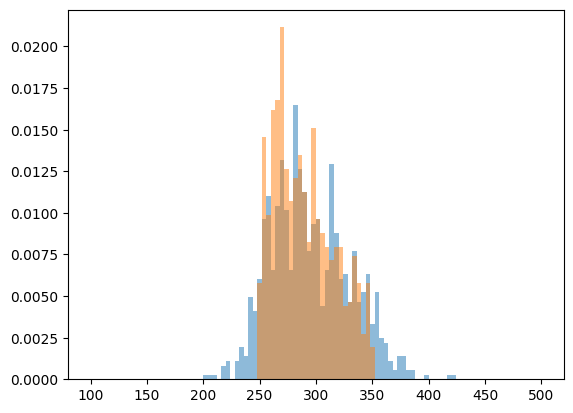

In [157]:
plt.hist(weight_scores, range=(100,500), bins=100, alpha=.5, density=True);
plt.hist(targets4, range=(100,500), bins=100, alpha=.5, density=True);

In [160]:
(np.array(targets4) < 250).sum()

0

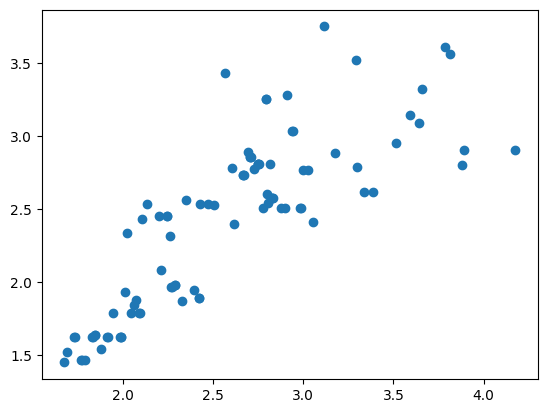

In [108]:
plt.scatter(sac_targets1, sac_scores)

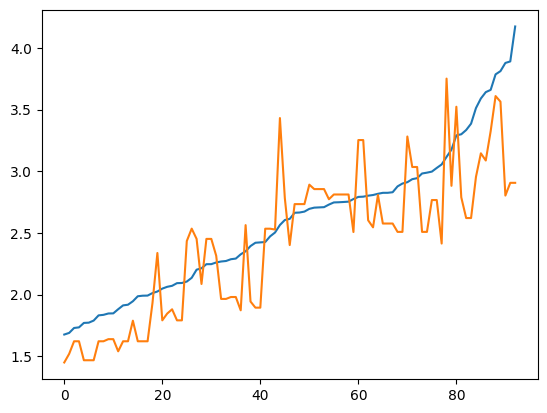

In [114]:
plt.plot(sorted(zip(sac_targets1, sac_scores)))

In [85]:
for _, sas, qed, clogp, weight in moses.iloc[1:10,[2,3,4,5]]:
          # mol, split, sas, qed, clogp, weight = sample
          print(sas, qed, clogp, weight)

ValueError: not enough values to unpack (expected 5, got 3)

In [100]:

for i in range(len(moses)):
          a,v=moses.iloc[i,3:5]
          print(a,v)
          break

0.897 1.681
